In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.stats import norm

In [2]:
def black_scholes_call_price(S, K, T, r, sigma):
    """Black-Scholes price of a European call option."""
    if T == 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def implied_vol_surface(strikes, maturities, sigma_func):
    """Generate implied volatilities on a grid using a custom function."""
    vols = np.zeros((len(maturities), len(strikes)))
    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            vols[i, j] = sigma_func(K, T)
    return vols


def compute_local_vol_surface(K, T, iv_surface, r=0.0):
    """Computes local volatility using Dupire's formula."""
    # Interpolator of implied vols
    iv_interp = RectBivariateSpline(T, K, iv_surface)

    local_vol = np.zeros_like(iv_surface)
    for i in range(len(T)):
        for j in range(len(K)):
            tau = T[i]
            strike = K[j]

            sigma = iv_interp(tau, strike)[0, 0]
            d_sigma_d_tau = iv_interp(tau, strike, dx=1)[0, 0]
            d_sigma_d_k = iv_interp(tau, strike, dy=1)[0, 0]
            d2_sigma_d_k2 = iv_interp(tau, strike, dy=2)[0, 0]

            if tau < 1e-4 or sigma < 1e-4:
                local_vol[i, j] = sigma
                continue

            d1 = (np.log(1.0) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

            numerator = d_sigma_d_tau + r * strike * d_sigma_d_k
            numerator *= 2 * sigma * tau
            denominator = (1 + strike * d_sigma_d_k / sigma)**2 + \
                          sigma * tau * (strike**2) * d2_sigma_d_k2

            if denominator <= 0 or numerator <= 0:
                local_vol[i, j] = sigma
            else:
                local_vol[i, j] = np.sqrt(numerator / denominator)

    return local_vol


def plot_surface(K, T, Z, title="Surface", zlabel="Value"):
    """Plot a 3D surface."""
    from mpl_toolkits.mplot3d import Axes3D
    K_mesh, T_mesh = np.meshgrid(K, T)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(K_mesh, T_mesh, Z, cmap="viridis", edgecolor='k', alpha=0.8)
    ax.set_xlabel("Strike (K)")
    ax.set_ylabel("Maturity (T)")
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

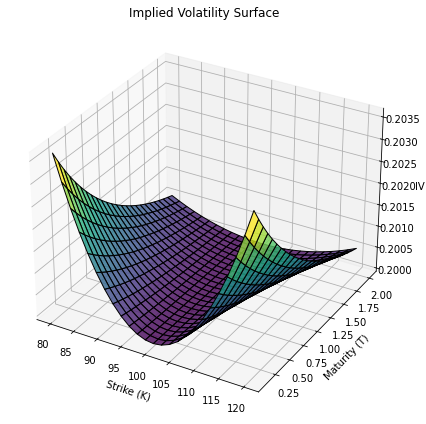

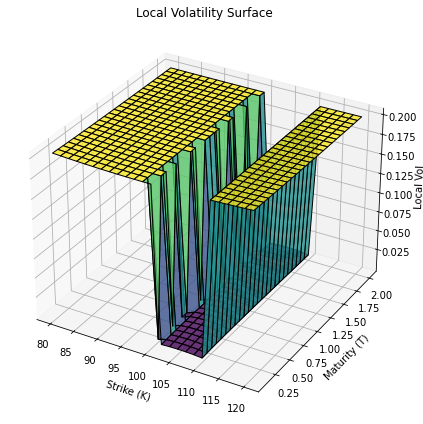

In [3]:
# Set grid
strikes = np.linspace(80, 120, 25)
maturities = np.linspace(0.1, 2.0, 25)

# Example implied volatility surface function
def example_iv(K, T):
    return 0.2 + 0.1 * np.exp(-T) * ((K - 100)/100)**2

# Generate synthetic implied vols
ivs = implied_vol_surface(strikes, maturities, example_iv)

# Plot implied volatility surface
plot_surface(strikes, maturities, ivs, title="Implied Volatility Surface", zlabel="IV")

# Compute Dupire local volatility surface
local_vols = compute_local_vol_surface(strikes, maturities, ivs, r=0.05)

# Plot local volatility surface
plot_surface(strikes, maturities, local_vols, title="Local Volatility Surface", zlabel="Local Vol")

In [12]:
res

'b'